# Implementing the Gradient Descent Algorithm

In this notebook, you'll be implementing the functions that build the gradient descent algorithm, namely:

* `sigmoid`: The sigmoid activation function.
* `output_formula`: The formula for the prediction.
* `error_formula`: The formula for the error at a point.
* `update_weights`: The function that updates the parameters with one gradient descent step.

Your goal is to find the boundary on a small dataset that has two classes:

<img src='../../../images/AI_Programming_with_Python_ND_P2_L_16.png' width=500px>

After you implement the gradient descent functions, be sure to run the `train` function. This will graph several of the lines that are drawn in successive gradient descent steps. It will also graph the error function, and you'll be able to see it decreasing as the number of epochs grows.

First, we'll start with some functions that will help us plot and visualize the data.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_points(X, y):
    """
    Plots a 2D dataset with points colored based on their binary labels.

    This function separates the data points into two groups ('admitted' and
    'rejected') based on their labels (1 or 0) and creates a scatter plot
    to visualize them.

    Args:
        X (np.ndarray): A 2D numpy array of shape (n_samples, 2) containing
            the feature data (coordinates for each point).
        y (np.ndarray): A 1D numpy array of shape (n_samples,) containing
            the binary labels (0 or 1) for each data point.

    Returns:
        None: The function directly generates a plot using matplotlib.
    """
    # Find the indices for admitted (y=1) and rejected (y=0) students.
    # np.argwhere returns the indices where the condition is true.
    admitted_indices = np.argwhere(y == 1)
    rejected_indices = np.argwhere(y == 0)

    # Select the corresponding data points from X using the indices.
    # The result is a 3D array, e.g., (num_points, 1, 2_features).
    admitted_points = X[admitted_indices]
    rejected_points = X[rejected_indices]

    # Create scatter plots for each group.
    # The list comprehensions extract the x and y coordinates for plotting.
    # For a point 's' with shape (1, 2), s[0][0] is the x-coord and s[0][1] is the y-coord.
    plt.scatter([s[0][0] for s in rejected_points], [s[0][1] for s in rejected_points], s=25, color='blue', edgecolor='k', label='Rejected')
    plt.scatter([s[0][0] for s in admitted_points], [s[0][1] for s in admitted_points], s=25, color='red', edgecolor='k', label='Admitted')


def display(m, b, color='g--'):
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    x = np.arange(-10, 10, 0.1)
    plt.plot(x, m*x+b, color)

## Reading and plotting the data

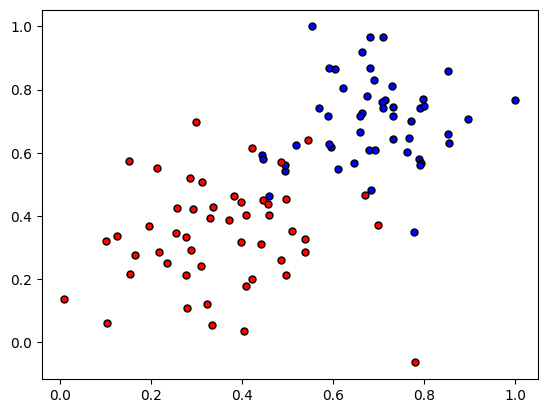

In [4]:
data = pd.read_csv('data.csv', header=None)

X = np.array(data[[0,1]])
y = np.array(data[2])

plot_points(X,y)
plt.show()


---

#### Implementing the basic functions
Here is your turn to shine. Implement the following formulas, as explained in the text.
- Sigmoid activation function

$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$

- Output (prediction) formula

$$
\hat{y} = \sigma(w_1 x_1 + w_2 x_2 + b)
$$

- Error function

$$
Error(y, \hat{y}) = - y \log(\hat{y}) - (1-y) \log(1-\hat{y})
$$

- The function that updates the weights

$$ 
w_i \longrightarrow w_i + \alpha (y - \hat{y}) x_i
$$

$$ 
b \longrightarrow b + \alpha (y - \hat{y})
$$


---

That formula is the **Binary Cross-Entropy Loss**, and while it might look a bit strange at first, it is the correct and standard error function for a binary classification problem like this one.

Let me break down why it works.

The formula is designed to handle the two possible cases for the true label `y` (which can only be 0 or 1).

### Case 1: The true label is 1 (`y = 1`)

The formula simplifies because the second term becomes zero:
`Error = - (1) * log(ŷ) - (1-1) * log(1-ŷ)`
`Error = -log(ŷ)`

*   If your model predicts correctly (`ŷ` is close to 1), `log(ŷ)` is close to 0, so the error is **low**.
*   If your model predicts incorrectly (`ŷ` is close to 0), `log(ŷ)` approaches negative infinity, so the error becomes **very high**.

This heavily penalizes the model for being confidently wrong.

### Case 2: The true label is 0 (`y = 0`)

Now, the first term becomes zero:
`Error = - (0) * log(ŷ) - (1-0) * log(1-ŷ)`
`Error = -log(1-ŷ)`

*   If your model predicts correctly (`ŷ` is close to 0), `1-ŷ` is close to 1, `log(1-ŷ)` is close to 0, and the error is **low**.
*   If your model predicts incorrectly (`ŷ` is close to 1), `1-ŷ` is close to 0, `log(1-ŷ)` approaches negative infinity, and the error becomes **very high**.

### Summary

This single formula elegantly handles both scenarios. It gives you a small error for correct predictions (when `ŷ` is close to `y`) and a very large error for incorrect predictions, which is exactly what you want to guide the learning process in gradient descent.

---



---

You are correct that the `error_formula` calculates the **loss**, but the `update_weights` function uses a much simpler term, `d_error = y - output`, to update the weights.

This is not a mistake! It's a very clever mathematical simplification. The term `y - output` is actually the **derivative (or gradient) of the log-loss error function** with respect to the model's inputs.

Let me show you.

### The Math Behind the Simplification

1.  **The Goal**: Gradient descent needs the derivative of the error with respect to the weights (`∂E/∂w`). Using the chain rule, this is:
    `∂E/∂w = ∂E/∂ŷ * ∂ŷ/∂z * ∂z/∂w`
    Where:
    *   `E` is the error (from `error_formula`)
    *   `ŷ` is the output (the prediction)
    *   `z` is the input to the sigmoid function (`np.dot(features, weights) + bias`)

2.  **The Magic**: When you work through the calculus for the sigmoid activation function and the log-loss error, these derivatives simplify beautifully:

    *   `∂E/∂ŷ` (Derivative of log-loss)
    *   `∂ŷ/∂z` (Derivative of the sigmoid function)

    When you multiply these two parts together (`∂E/∂ŷ * ∂ŷ/∂z`), the complex terms cancel out, and you are left with something surprisingly simple:
    `∂E/∂z = ŷ - y`

    *(Note: Your code uses `y - output`, which is just the negative of this, `y - ŷ`. The direction is handled by whether you add or subtract in the weight update step.)*

3.  **The Final Step**: Now we just need the last part of the chain rule, `∂z/∂w`, which is simply the input features `x`.

    So, the full gradient for the weights is `(y - ŷ) * x`.

### Why the Code is Correct

The line `d_error = y - output` is not calculating the error itself. It is calculating the **gradient** of the error. The variable name `d_error` is a bit misleading; it should probably be called `error_gradient` or something similar.

The `update_weights` function is therefore using the correct gradient to update the weights and bias:

```python
# This is the gradient of the error
d_error = y - output 

# Update rule: new_weight = old_weight + learning_rate * gradient
weights += learnrate * d_error * x 
bias += learnrate * d_error 
```

**In short:** The `error_formula` is used to measure *how well the model is doing* (the loss), but the much simpler `y - output` is used to calculate the *direction and magnitude of the change* needed for the weights (the gradient).

---

In [6]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Output (prediction) formula
def output_formula(features, weights, bias):
    return sigmoid(np.dot(features, weights) + bias)

# Error (log-loss) formula
# output is y_hat and y is real data 
def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

# Gradient descent step
def update_weights(x, y, weights, bias, learnrate):
    output = output_formula(x, weights, bias)
    d_error = y - output
    weights += learnrate * d_error * x
    bias += learnrate * d_error
    return weights, bias


---

#### Understanding Logistic Regression Components

### Sigmoid Function

```python
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
```

The sigmoid function transforms any real-valued number into a value between 0 and 1. This is crucial for binary classification problems where we need to interpret the output as a probability.

Mathematically, the sigmoid function is defined as:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

This function has an S-shaped curve that asymptotically approaches 0 as $x \to -\infty$ and 1 as $x \to +\infty$. The steepest part of the curve is at $x = 0$, where $\sigma(0) = 0.5$.

### Output Formula

```python
def output_formula(features, weights, bias):
    return sigmoid(np.dot(features, weights) + bias)
```

This function computes the predicted probability that an example belongs to the positive class. It first calculates the linear combination of features and weights (plus a bias term), then applies the sigmoid function to map this value to the [0,1] interval.

The mathematical representation is:

$$\hat{y} = \sigma(\mathbf{w}^T\mathbf{x} + b)$$

Where:
- $\mathbf{w}$ is the weight vector
- $\mathbf{x}$ is the feature vector
- $b$ is the bias term
- $\sigma$ is the sigmoid function

### Error Formula (Log-Loss)

```python
def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)
```

This implements the binary cross-entropy loss function, also known as log-loss. It measures how well the model's probabilistic predictions match the actual binary outcomes.

Mathematically:

$$L(y, \hat{y}) = -[y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$$

This loss function has several important properties:
- When $y = 1$ and $\hat{y} \approx 1$, the loss approaches 0
- When $y = 1$ but $\hat{y} \approx 0$, the loss approaches infinity (severely penalizing confident but wrong predictions)
- Similarly for $y = 0$, the loss behaves symmetrically

### Gradient Descent Update

```python
def update_weights(x, y, weights, bias, learnrate):
    output = output_formula(x, weights, bias)
    d_error = y - output
    weights += learnrate * d_error * x
    bias += learnrate * d_error
    return weights, bias
```

This function implements a single step of gradient descent to update the weights and bias. The key components are:

1. Calculate the current prediction using the output formula
2. Compute the error derivative (`d_error = y - output`)
3. Update weights and bias in the direction that reduces the error

The weight update rule is:

$$\mathbf{w} \leftarrow \mathbf{w} + \alpha (y - \hat{y}) \mathbf{x}$$

And the bias update rule is:

$$b \leftarrow b + \alpha (y - \hat{y})$$

Where $\alpha$ is the learning rate that controls the step size.

## Numerical Example

Let's work through a concrete example to illustrate how these functions operate in practice.

Suppose we have:
- A single feature $x = 2$
- Initial weight $w = 0.5$
- Initial bias $b = -1$
- Learning rate $\alpha = 0.1$
- True label $y = 1$ (positive class)

### Step 1: Calculate the predicted output

```
Linear combination = dot(x, w) + b = 2 * 0.5 + (-1) = 1 - 1 = 0
```

Now apply the sigmoid function:
```
output = sigmoid(0) = 1 / (1 + exp(-0)) = 1 / (1 + 1) = 0.5
```

So our model predicts a 50% probability of the example belonging to the positive class.

### Step 2: Calculate the error

```
error = -y*log(output) - (1-y)*log(1-output)
      = -(1)*log(0.5) - (1-1)*log(1-0.5)
      = -log(0.5) - 0
      = -(-0.693)
      = 0.693
```

This is the cross-entropy loss for this prediction.

### Step 3: Update the weights and bias

First, calculate the error derivative:
```
d_error = y - output = 1 - 0.5 = 0.5
```

Now update the weight:
```
w_new = w + learning_rate * d_error * x
      = 0.5 + 0.1 * 0.5 * 2
      = 0.5 + 0.1
      = 0.6
```

And update the bias:
```
b_new = b + learning_rate * d_error
      = -1 + 0.1 * 0.5
      = -1 + 0.05
      = -0.95
```

### Step 4: Verify improvement with the new parameters

Let's calculate the new output with the updated parameters:
```
Linear combination = 2 * 0.6 + (-0.95) = 1.2 - 0.95 = 0.25
output_new = sigmoid(0.25) = 1 / (1 + exp(-0.25)) ≈ 0.562
```

Our prediction has improved from 0.5 to approximately 0.562, moving closer to the true label of 1.

Let's calculate the new error:
```
error_new = -log(0.562) ≈ 0.576
```

The error has decreased from 0.693 to 0.576, confirming that our gradient descent step moved in the right direction.

## Conceptual Understanding

What's happening in this example:
1. We start with a prediction of 0.5, which is neutral (neither class 0 nor class 1)
2. The true label is 1, so we want to increase our prediction
3. The gradient descent step adjusts our weights and bias to make the model predict higher values for inputs like this one
4. After one update, our prediction increases to 0.562
5. If we continued this process for many iterations across multiple examples, the model would gradually learn to classify examples correctly

The beauty of this algorithm lies in its elegant mathematical formulation:
- When predictions are too low (output < y), weights increase for positive features
- When predictions are too high (output > y), weights decrease for positive features
- The learning rate controls how quickly parameters change, balancing convergence speed against stability

With this implementation, the model learns to minimize the log-loss by adjusting its parameters in the direction that reduces prediction errors.

## Real-World Example: Predicting Email Spam

Imagine we're building a simple spam filter that predicts whether an email is spam (1) or not spam (0) based on three features:
1. Number of exclamation marks in the email
2. Presence of the word "offer" (0 for absent, 1 for present)
3. Email length (in hundreds of characters)

### Sample Data

Let's say we have the following training example:
- Features: [5, 1, 2.4] (5 exclamation marks, contains "offer", 240 characters)
- True label: y = 1 (this is spam)

Let's initialize our model with:
- Weights: w = [0.1, 0.2, -0.1]
- Bias: b = -0.5
- Learning rate: α = 0.01

### Step-by-Step Calculation

#### 1. Calculate the model's prediction

First, we compute the linear combination (dot product):
```
z = np.dot(features, weights) + bias
  = (5 × 0.1) + (1 × 0.2) + (2.4 × -0.1) + (-0.5)
  = 0.5 + 0.2 - 0.24 - 0.5
  = -0.04
```

Then we apply the sigmoid function:
```
output = sigmoid(-0.04)
       = 1 / (1 + e^(0.04))
       = 1 / 1.0408
       ≈ 0.49
```

Our model predicts this email has about a 49% chance of being spam.

#### 2. Calculate the error (log-loss)

```
error = -y × log(output) - (1-y) × log(1-output)
      = -(1) × log(0.49) - (0) × log(1-0.49)
      = -log(0.49)
      ≈ 0.713
```

#### 3. Update the weights and bias

First, calculate the error derivative:
```
d_error = y - output = 1 - 0.49 = 0.51
```

Now update each weight:
```
w[0]_new = w[0] + learning_rate × d_error × features[0]
         = 0.1 + 0.01 × 0.51 × 5
         = 0.1 + 0.0255
         = 0.1255

w[1]_new = w[1] + learning_rate × d_error × features[1]
         = 0.2 + 0.01 × 0.51 × 1
         = 0.2 + 0.0051
         = 0.2051

w[2]_new = w[2] + learning_rate × d_error × features[2]
         = -0.1 + 0.01 × 0.51 × 2.4
         = -0.1 + 0.01224
         = -0.08776
```

And update the bias:
```
b_new = b + learning_rate × d_error
      = -0.5 + 0.01 × 0.51
      = -0.5 + 0.0051
      = -0.4949
```

#### 4. Verify improvement with new parameters

Let's calculate the new prediction:
```
z_new = (5 × 0.1255) + (1 × 0.2051) + (2.4 × -0.08776) + (-0.4949)
      = 0.6275 + 0.2051 - 0.21062 - 0.4949
      = 0.12708

output_new = sigmoid(0.12708)
           = 1 / (1 + e^(-0.12708))
           ≈ 0.532
```

Our prediction has improved from 0.49 to 0.532, moving closer to the true label of 1.

Let's calculate the new error:
```
error_new = -log(0.532) ≈ 0.631
```

The error has decreased from 0.713 to 0.631, confirming that our gradient descent step moved in the right direction.

## Interpreting the Results

After this update, our model has:
1. Increased the weight for exclamation marks (from 0.1 to 0.1255)
2. Slightly increased the weight for the word "offer" (from 0.2 to 0.2051)
3. Made the weight for email length less negative (from -0.1 to -0.08776)
4. Made the bias less negative (from -0.5 to -0.4949)

These changes make intuitive sense:
- More exclamation marks tend to indicate spam, so the model increases this weight
- The presence of "offer" is also correlated with spam in our example
- The model initially thought longer emails were less likely to be spam (negative weight), but this example suggests that relationship isn't as strong as initially thought

## Training Process in Practice

In a real-world scenario:
1. We would iterate this process across thousands of training examples
2. Process all examples either in batches (mini-batch gradient descent) or one at a time (stochastic gradient descent)
3. Repeat for multiple epochs (passes through the entire dataset)
4. Monitor the average loss to ensure it's decreasing

Eventually, the model would learn weights that capture the true relationship between features and the probability of an email being spam.

## Why This Works for Binary Classification

The beauty of logistic regression is that it outputs probabilities between 0 and 1. To make a final classification, we simply apply a threshold (commonly 0.5):
- If output ≥ 0.5, classify as spam
- If output < 0.5, classify as not spam

In our example, after one update, the prediction crossed this threshold (from 0.49 to 0.532), so the model would now classify this email as spam, which matches the true label.

This approach can be extended to many real-world binary classification problems:
- Medical diagnosis (disease present/absent)
- Fraud detection (fraudulent/legitimate)
- Customer churn prediction (will churn/won't churn)
- Sentiment analysis (positive/negative)

## Training function
This function will help us iterate the gradient descent algorithm through all the data, for a number of epochs. It will also plot the data, and some of the boundary lines obtained as we run the algorithm.

In [ ]:
np.random.seed(44)

epochs = 100
learnrate = 0.01

def train(features, targets, epochs, learnrate, graph_lines=False):
    
    errors = []
    n_records, n_features = features.shape
    last_loss = None
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)
    bias = 0
    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features, targets):
            output = output_formula(x, weights, bias)
            error = error_formula(y, output)
            weights, bias = update_weights(x, y, weights, bias, learnrate)
        
        # Printing out the log-loss error on the training set
        out = output_formula(features, weights, bias)
        loss = np.mean(error_formula(targets, out))
        errors.append(loss)
        if e % (epochs / 10) == 0:
            print("\n========== Epoch", e,"==========")
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            predictions = out > 0.5
            accuracy = np.mean(predictions == targets)
            print("Accuracy: ", accuracy)
        if graph_lines and e % (epochs / 100) == 0:
            display(-weights[0]/weights[1], -bias/weights[1])
            

    # Plotting the solution boundary
    plt.title("Solution boundary")
    display(-weights[0]/weights[1], -bias/weights[1], 'black')

    # Plotting the data
    plot_points(features, targets)
    plt.show()

    # Plotting the error
    plt.title("Error Plot")
    plt.xlabel('Number of epochs')
    plt.ylabel('Error')
    plt.plot(errors)
    plt.show()

## Time to train the algorithm!
When we run the function, we'll obtain the following:
- 10 updates with the current training loss and accuracy
- A plot of the data and some of the boundary lines obtained. The final one is in black. Notice how the lines get closer and closer to the best fit, as we go through more epochs.
- A plot of the error function. Notice how it decreases as we go through more epochs.


========== Epoch 0 ==========
Train loss:  0.6619731146290033
Accuracy:  0.62

========== Epoch 1 ==========
Train loss:  0.6538675649590735
Accuracy:  0.61

========== Epoch 2 ==========
Train loss:  0.6463538198657929
Accuracy:  0.61

========== Epoch 3 ==========
Train loss:  0.6390243546284473
Accuracy:  0.6

========== Epoch 4 ==========
Train loss:  0.6317549020011602
Accuracy:  0.59

========== Epoch 5 ==========
Train loss:  0.6245286207332458
Accuracy:  0.6

========== Epoch 6 ==========
Train loss:  0.6173636247607152
Accuracy:  0.62

========== Epoch 7 ==========
Train loss:  0.6102847106790122
Accuracy:  0.62

========== Epoch 8 ==========
Train loss:  0.6033135311162181
Accuracy:  0.65

========== Epoch 9 ==========
Train loss:  0.5964661412200785
Accuracy:  0.66


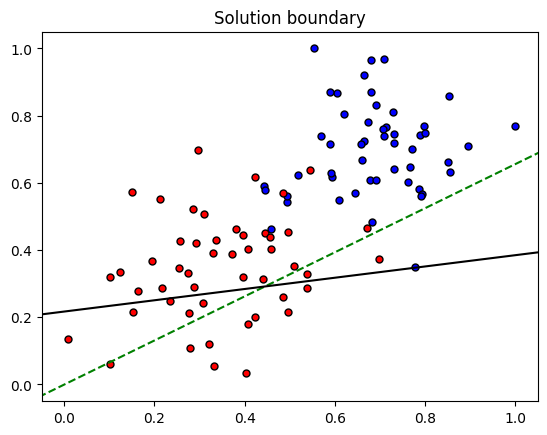

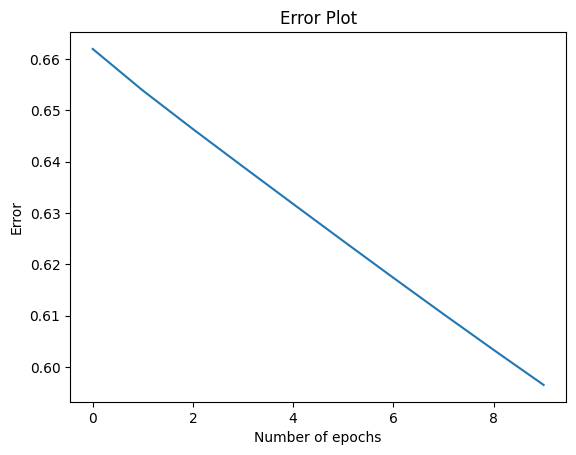

In [10]:
train(X, y, epochs, learnrate, True)